# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Taylor Galdi

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2024-12-13 16:22:26.777234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

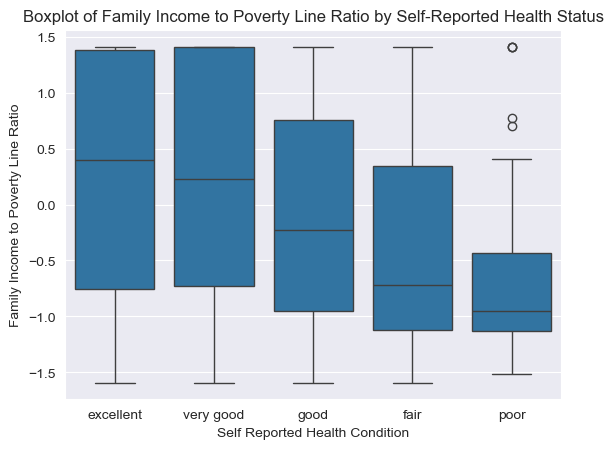

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

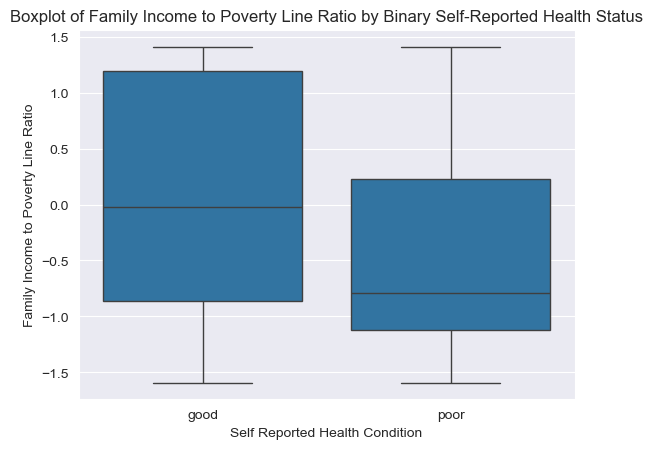

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

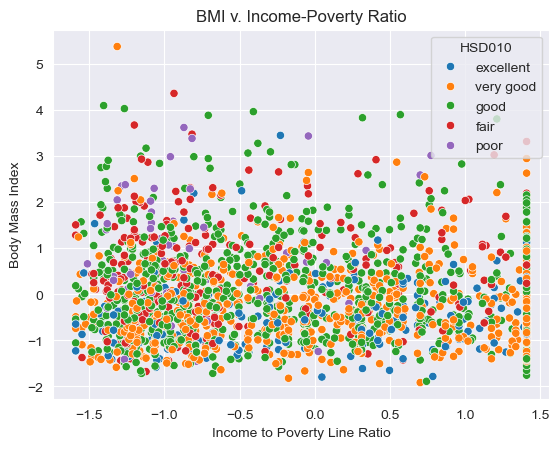

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanestarget = nhanes_scaled

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)
print(nhanes_scaled.head())

       DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -0.646584   
73576 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -1.539259   
73579 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -1.539259   
73581 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -0.646584   
73584 -0.057306  0.1282

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

Instead of choosing an arbitrary number of components for my PCA, analysing the variation explained by those components, and then re-fitting the model with the new number of components, I am instead going to chart all the components for this data and then narrow it down based on what I am seeing in the barplot of explained variance. If I had a compelling reason to pre-determine the number of clusters and 'test' them out (i.e. because of theory or whatnot), the progression of steps that the notebook asks would make sense, but because I don't have that subject-matter expertise, I did not go in that order.

In [8]:
# scale data (without scaling the index)
# ----------
scaler = StandardScaler()
X = scaler.fit_transform(nhanes_scaled)

# Convert the scaled data back into a DataFrame with the original column names and index
X = pd.DataFrame(X, columns=nhanes_scaled.columns, index=nhanes_scaled.index)

# Verify the result
print(X.head())

       DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -0.646584   
73576 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -1.539259   
73579 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -1.539259   
73581 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -0.646584   
73584 -0.057306  0.1282

In [9]:
# apply PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(X)

### Scree Plot(s) of Explained Variance

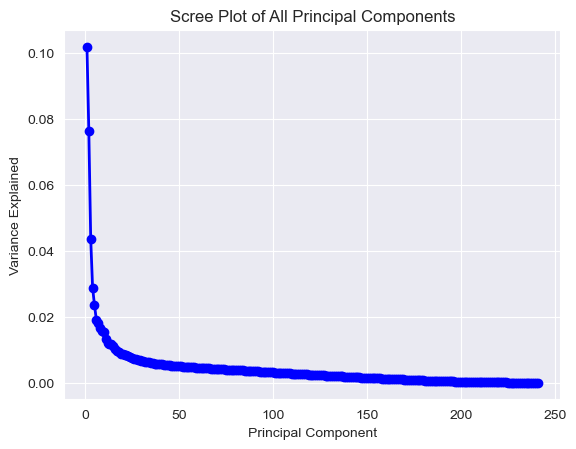

In [10]:
# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot of All Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Obviously, this is far too many components. There is an elbow here somewhere between 0-50, so let's just plot the first 20 components to see if we can see where there is a reasonable trade off between number of components and amount of variation explained. 

In [11]:
# Fit PCA model for less components 
pca = PCA(n_components=20)
pca.fit(X)

PCA(n_components=20)

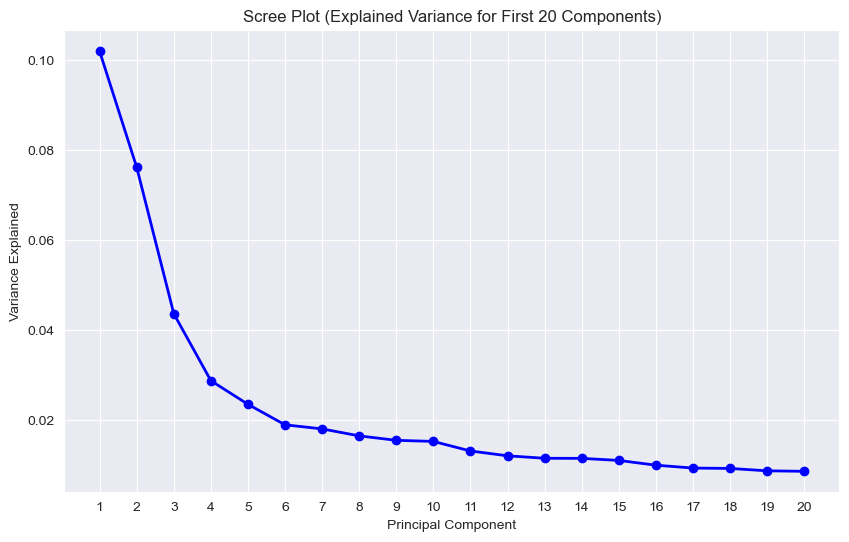

In [12]:
# PC values are the principal component indices (1, 2, 3,...)
PC_values = np.arange(pca.n_components_) + 1

# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

# Title and labels
plt.title('Scree Plot (Explained Variance for First 20 Components)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(PC_values)
plt.grid(True)

### Barplot of Components

/var/folders/51/tvqz_23j083bt8bcsjfhnyk40000gn/T/ipykernel_42239/3564382604.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(range(1, len(explained_variance_ratio) + 1)),


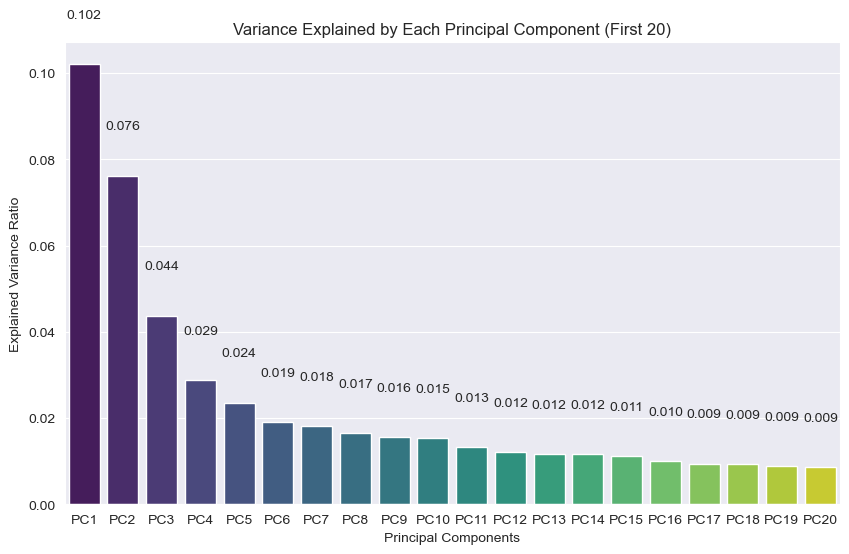

In [13]:
# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar plot to show the variance explained by each component
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(range(1, len(explained_variance_ratio) + 1)), 
                 y=explained_variance_ratio, 
                 palette='viridis')

# Add annotations for each bar with the value of explained variance
for i, v in enumerate(explained_variance_ratio):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title('Variance Explained by Each Principal Component (First 20)')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(ticks=range(len(explained_variance_ratio)), labels=[f'PC{i+1}' for i in range(len(explained_variance_ratio))])
plt.grid(True, axis='y')

# Show the plot
plt.show()

### How many components will you use to fit a supervised learning model?

Based on what we are seeing here and also in the scree plot, I am going to choose 5 components. Because our next step is to apply PCA for only 2 components, I will apply the PCA with 5 components after the following section, before the clustering.

### 2D Scatterplot of the first two components

In [14]:
# apply PCA
# ----------
pca2 = PCA(n_components=2)
pca2_result = pca2.fit_transform(X)

In [15]:
# convert into a dataframe and re-assign SQN as index
# ----------
pca2_df = pd.DataFrame(data=pca2_result, 
                       columns=['principal component 1', 'principal component 2'],
                       index=nhanes_scaled.index)

# Now pca2_df should have the SEQN (index) column
print(pca2_df.head())

       principal component 1  principal component 2
SEQN                                               
73568               9.527811              -0.816227
73576              -5.838339              -3.692573
73579              -0.719454              -2.573198
73581               3.533627              -2.576984
73584              -6.872094              -4.194239


In [16]:
#Now we have to do the same for our target 
SQNnhanestarget = nhanestarget.reset_index()

In [17]:
# Merge the PCA results with the target labels to align the data
merged_df = pca2_df.merge(SQNnhanestarget[['SEQN', 'HSD010','HSD010_binary']], on='SEQN', how='inner')

# Check the merged DataFrame
print(merged_df.head())

    SEQN  principal component 1  principal component 2     HSD010  \
0  73568               9.527811              -0.816227  excellent   
1  73576              -5.838339              -3.692573  excellent   
2  73579              -0.719454              -2.573198  very good   
3  73581               3.533627              -2.576984  very good   
4  73584              -6.872094              -4.194239       good   

  HSD010_binary  
0          good  
1          good  
2          good  
3          good  
4          good  


In [18]:
#Check the original dataframe to make sure that the SEQN aligns with the target 
print(nhanestarget.head())

       DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ845   PAAQUEX    SMQ860  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.646584 -0.484200  1.125008   
73576 -0.057306  0.128246  0.080373  ... -1.539259 -0.484200  1.125008   
73579 -0.057306  0.128246 -0.189513  ... -1.539259  2.065262 -0.888883   
73581 -0.057306  0.128246  0.080373  ... -0.646584 -0.484200  1.125008   
73584 -0.057306  0.1282

Plotting excellent: 239 points
Plotting very good: 672 points
Plotting good: 821 points
Plotting fair: 273 points
Plotting poor: 59 points


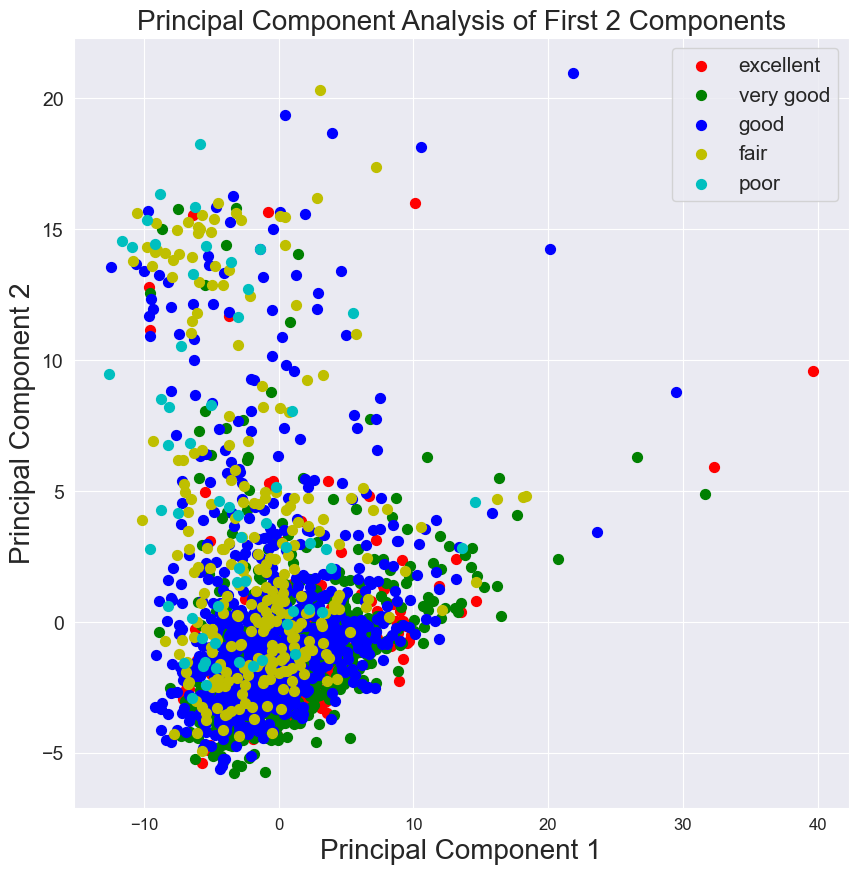

In [19]:
# Update the targets list to include all categories in the HDS10
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y', 'c']

# Plotting
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Principal Component Analysis of First 2 Components", fontsize=20)

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Use the merged DataFrame to filter for the target
    indicesToKeep = merged_df['HSD010'] == target
    print(f"Plotting {target}: {sum(indicesToKeep)} points") 
    if sum(indicesToKeep) > 0:
        # Plot the points for the current category (target)
        plt.scatter(merged_df.loc[indicesToKeep, 'principal component 1'],
                    merged_df.loc[indicesToKeep, 'principal component 2'], 
                    c=color, label=target, s=50)

# Add a legend
plt.legend(targets, prop={'size': 15})
plt.show()

Okay, that's a little messy, let's look at the binary version of the target.

Plotting good: 1732 points
Plotting poor: 332 points


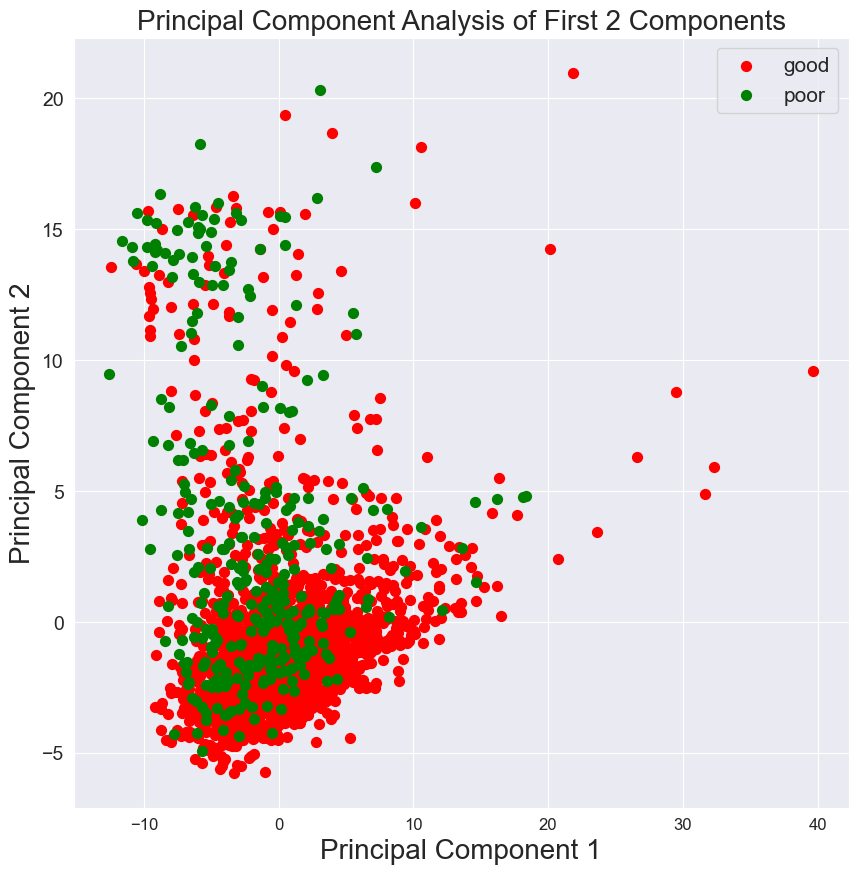

In [20]:
#Update the targets list to include all categories in the HDS10_binary
targets = [ 'good', 'poor']
colors = ['r', 'g']

# Plotting
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Principal Component Analysis of First 2 Components", fontsize=20)

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Use the merged DataFrame to filter for the target
    indicesToKeep = merged_df['HSD010_binary'] == target
    print(f"Plotting {target}: {sum(indicesToKeep)} points")  
    if sum(indicesToKeep) > 0:
        # Plot the points for the current category (target)
        plt.scatter(merged_df.loc[indicesToKeep, 'principal component 1'],
                    merged_df.loc[indicesToKeep, 'principal component 2'], 
                    c=color, label=target, s=50)

# Add a legend
plt.legend(targets, prop={'size': 15})
plt.show()

So, unlike the notebook we did in class, this mapping (though now better because the target's binarized), is not really telling us much. Obviously we are doing this as a requirement for the project, but otherwise, I would take this portion out and just stick with my 5 components (which I'm doing directly below).

## PCA With Chosen Number of Components (5)

In [21]:
# apply PCA
# ----------
pca5 = PCA(n_components=5)
pca5_result = pca5.fit_transform(X)

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I am choosing the k-means clustering algorithm. Although k-means clustering (unlike DBSCAN) requires you to have a pre-determined number of clusters in mind, we can use inertia values to find the ideal number of clusters (k) to use. The k-means algorithm will assign cases to one of the clusters, iterating through while calculating each cluster's centroid.

### Cluster nhanes

In [22]:
# load libraries 
# ----------
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn import metrics

# settings
%matplotlib inline

In [23]:
#Scale the data for this section
scaler = StandardScaler()
kmeansscale= scaler.fit_transform(nhanes_scaled)
kmeansscale=pd.DataFrame(kmeansscale, columns=nhanes_scaled.columns)

Inertia values:
1 : 485040.0
2 : 456520.723793382
3 : 430162.7418399672
4 : 418161.7907543633
5 : 412132.7762390529
6 : 407214.96506037837
7 : 401453.54964757676
8 : 398272.3905769178
9 : 395300.421857825


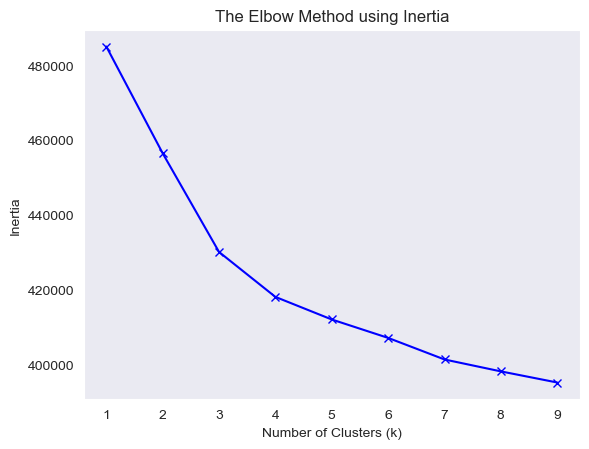

In [24]:
# Initialize lists to store inertia values
inertias = []
mapping = {}
K = range(1, 10)

# Fit K-means for different values of k
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(kmeansscale)
    
    # Get intertia values
    inertias.append(kmeanModel.inertia_)
    
    # Store the mappings for easy access
    mapping[k] = inertias[-1]

print("Inertia values:")
for key, val in mapping.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Inertia
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()
plt.show()

We extracted and plotted the inertia values (the sum of squared distances from each data point to a cluster center) for different k (clusters) in order to choose the ideal number of clusters. Based on this graph, I am going to use three clusters, as that seems like the steepest part of the elbow to me. Even with the intertia values, my understanding is that this is sort of a subjective choice (i.e. there's no predetermined formula) but that the choice for number of clusters has to be defensible in a theoretical sense (though for the purposes of this project I don't necessarily have the domain-specific knowledge of theory to back up this decision of cluster selection).

In [25]:
# set random seed
np.random.seed(10)

In [26]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(kmeansscale)

In [27]:
#Comment out for Kasey
# print the centers 
#print("Centers")
#print(kmeans.cluster_centers_)
#print()

# print labels
#print("Labels")
#print(kmeans.labels_)
#print()

# print coordinates and labels 
#for point, label in zip(kmeansscale, kmeans.labels_):
    #print("Coordinates:", point, "Label:", label)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

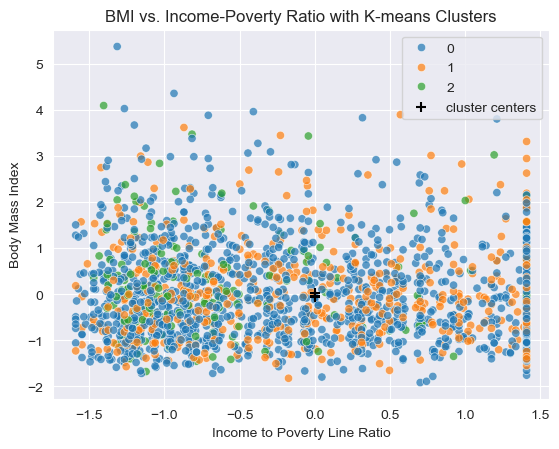

In [28]:
# Store the cluster labels
kmeans_labels = kmeans.labels_

# Recreate the scatter plot with BMI vs Income-to-Poverty Ratio
ax = sns.scatterplot(x="INDFMPIR", y="BMXBMI", 
                     hue=kmeans_labels, 
                     palette="tab10", 
                     data=kmeansscale, 
                     legend="full",
                    alpha=0.7)

# Plot the cluster centers on top of the scatter plot
centers = kmeans.cluster_centers_

# Plotting each cluster center (use a larger size and '+' marker)
ax.scatter(centers[:, 0], centers[:, 1], s=50,  marker='+', c='black', label='cluster centers')

# Set the axis labels and plot title
ax.set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
ax.set_title("BMI vs. Income-Poverty Ratio with K-means Clusters")

# Show the plot with the legend
plt.legend()
plt.show()

So, from what I am seeing here, because the clusters look so messy in this feature space (the cluster centers are close to one another and the clusters are disorganized), it is telling me that 'BMI' and "Income to Poverty Line Ratio' are not necessarily the most significant features that organize our clusters. If this were my research, I would probably leave this out of the final analysis.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [29]:
# set random seed
np.random.seed(10)

In [30]:
# specify kmeans algorithm
# ----------
kmeanspca = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(pca5_result)

In [31]:
#Comment out for Kasey
# print the centers 
#print("Centers")
#print(kmeanspca.cluster_centers_)
#print()

# print labels
#print("Labels")
#print(kmeanspca.labels_)
#print()

# print coordinates and labels 
#for point, label in zip (pca5_result, kmeanspca.labels_):
    #print("Coordinates:", point, "Label:", label)

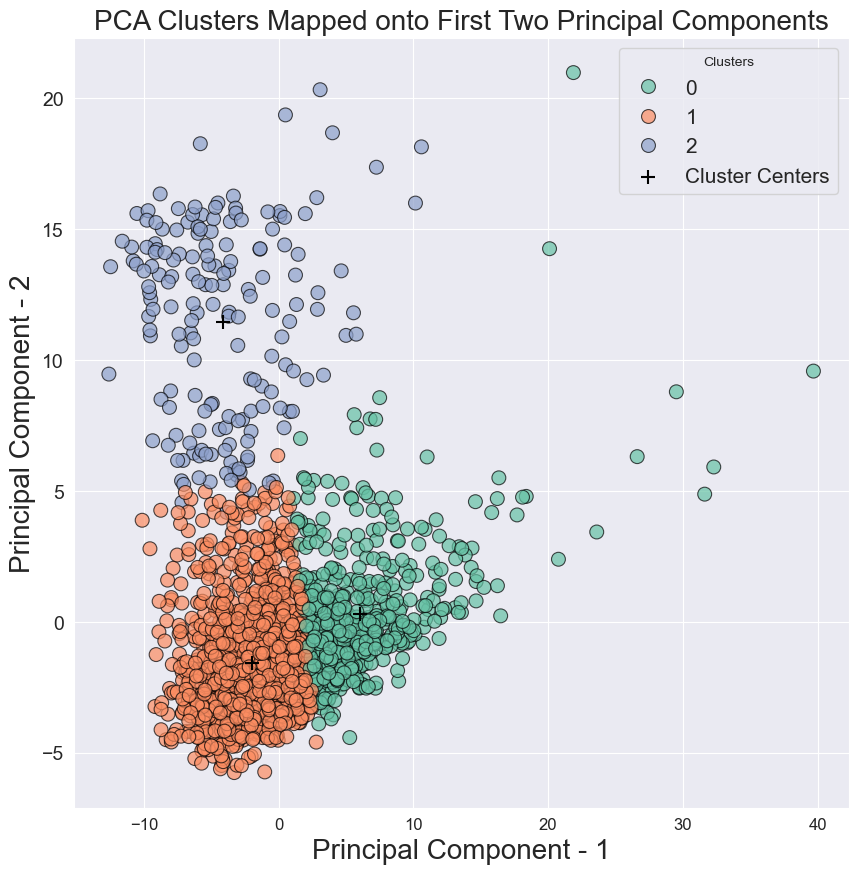

In [32]:
# Store the cluster labels
pcalabels = kmeanspca.labels_
pcacenters = kmeanspca.cluster_centers_

# Add pcalabels to the merged_df DataFrame for hue mapping
merged_df['pcalabels'] = pcalabels

# figure settings
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1', fontsize=20)
plt.ylabel('Principal Component - 2', fontsize=20)
plt.title("PCA Clusters Mapped onto First Two Principal Components", fontsize=20)

# Plot the scatterplot with K-means clusters as hue
sns.scatterplot(data=merged_df, 
                x='principal component 1', 
                y='principal component 2', 
                hue='pcalabels',  # Using the labels from the merged_df
                palette='Set2',  # Color palette
                s=100,  # Size of the points
                edgecolor='black',  # Black edges for better visibility
                alpha=0.7)  # Slight transparency

# Plot the cluster centers 
plt.scatter(pcacenters[:, 0], pcacenters[:, 1], s=100, c='black', marker='+', label='Cluster Centers')

# Show the legend
plt.legend(title="Clusters", prop={'size': 15})

# Show the plot
plt.show()

This looks a lot better than when we mapped our target variable (HSD010 and HSD010_binary) onto our first two principal components earlier in the notebook. Even though it is charted this way, I believe the way we should interpret this is to say that it looks like our components (at least our first two) align with our clusters, which themselves are trained on our PCA features. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [33]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# Sklearn libraries
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

# Keras libraries
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [34]:
# Convert HSD010_binary back to numeric, mapping 'good' to 0 and 'poor' to 1
NNnhanes_target=nhanestarget
NNnhanes_target['HSD010_binary'] = NNnhanes_target['HSD010_binary'].map({'good': 0, 'poor': 1})
X=NNnhanes_target.drop(['HSD010', 'HSD010_binary'], axis = 1) # drop out any columns that aren't features

In [35]:
NNnhanes_target.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,HSD010_binary
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,excellent,0
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,excellent,0
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,very good,0
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,very good,0
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good,0


In [36]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = X 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [37]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [38]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
originalNN=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Convert the history dictionary to a DataFrame
originalNN = pd.DataFrame(originalNN.history)


Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 144ms/step - accuracy: 0.8198 - loss: 0.4659 - val_accuracy: 0.8430 - val_loss: 0.3818
Epoch 2/10
8/8 - 0s - 14ms/step - accuracy: 0.8663 - loss: 0.3367 - val_accuracy: 0.8450 - val_loss: 0.3649
Epoch 3/10
8/8 - 0s - 13ms/step - accuracy: 0.8818 - loss: 0.2968 - val_accuracy: 0.8585 - val_loss: 0.3494
Epoch 4/10
8/8 - 0s - 14ms/step - accuracy: 0.8921 - loss: 0.2617 - val_accuracy: 0.8566 - val_loss: 0.3455
Epoch 5/10
8/8 - 0s - 14ms/step - accuracy: 0.9109 - loss: 0.2327 - val_accuracy: 0.8566 - val_loss: 0.3394
Epoch 6/10
8/8 - 0s - 14ms/step - accuracy: 0.9186 - loss: 0.2091 - val_accuracy: 0.8624 - val_loss: 0.3403
Epoch 7/10
8/8 - 0s - 14ms/step - accuracy: 0.9309 - loss: 0.1858 - val_accuracy: 0.8585 - val_loss: 0.3441
Epoch 8/10
8/8 - 0s - 14ms/step - accuracy: 0.9419 - loss: 0.1663 - val_accuracy: 0.8643 - val_loss: 0.3460
Epoch 9/10
8/8 - 0s - 14ms/step - accuracy: 0.9490 - loss: 0.1474 - val_accuracy: 0.8547 - val_loss: 0.3549
Epoch 10/10
8/8 - 0s - 14ms/step - acc

### Neural Network on Principal Components

In [39]:
# Convert the PCA result to a DataFrame 
pca5_df = pd.DataFrame(data = pca5_result, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                'principal component 3',
                                'principal component 4',
                                'principal component 5'])

In [40]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] 
X = pca5_df # using our 5 component PCA as the features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [41]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [42]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
PCANN=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Convert the history dictionary to a DataFrame
PCANN = pd.DataFrame(PCANN.history)


Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 131ms/step - accuracy: 0.4141 - loss: 0.6957 - val_accuracy: 0.7326 - val_loss: 0.6900
Epoch 2/10
8/8 - 0s - 13ms/step - accuracy: 0.8043 - loss: 0.6860 - val_accuracy: 0.8469 - val_loss: 0.6797
Epoch 3/10
8/8 - 0s - 13ms/step - accuracy: 0.8353 - loss: 0.6762 - val_accuracy: 0.8488 - val_loss: 0.6694
Epoch 4/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6663 - val_accuracy: 0.8488 - val_loss: 0.6583
Epoch 5/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6555 - val_accuracy: 0.8488 - val_loss: 0.6462
Epoch 6/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6434 - val_accuracy: 0.8488 - val_loss: 0.6328
Epoch 7/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6300 - val_accuracy: 0.8488 - val_loss: 0.6180
Epoch 8/10
8/8 - 0s - 20ms/step - accuracy: 0.8359 - loss: 0.6156 - val_accuracy: 0.8488 - val_loss: 0.6018
Epoch 9/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.5991 - val_accuracy: 0.8488 - val_loss: 0.5846
Epoch 10/10
8/8 - 0s - 14ms/step - acc

### Neural Network on Principal Components + Cluster Membership (Clustering on Original Data)

Because of the way the project notebook is worded, I am creating neural networks that have our PCA results as features, but that vary based on whether they include as an additional feature the cluster membership from the algorithm trained on either the original data or on the PCA results). It will be interesting to see how these two neural networks differ in their performance.

In [43]:
# Add cluster labels (from cluster algorithm trained on the ORIGINAL data) to the PCA DataFrame (as an additional feature)
kmeans_labels = kmeans.labels_
pca5_df['cluster_label'] = kmeans_labels
print(pca5_df.head())

   principal component 1  principal component 2  principal component 3  \
0               9.527811              -0.816224              -1.867092   
1              -5.838339              -3.692573               3.805729   
2              -0.719454              -2.573201               0.907918   
3               3.533627              -2.576981              -3.249169   
4              -6.872095              -4.194240               0.886885   

   principal component 4  principal component 5  cluster_label  
0              -2.109586              -3.928154              1  
1              -1.029421               0.395513              0  
2              -4.754837              -1.798339              0  
3              -0.406113               3.996848              1  
4              -0.847390              -0.529646              0  


In [44]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] 
X = pca5_df # using our 5 component PCA and cluster membership as the features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [45]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [46]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
OGClusterNN=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Convert the history dictionary to a DataFrame
OGClusterNN = pd.DataFrame(OGClusterNN.history)

Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 142ms/step - accuracy: 0.3766 - loss: 0.7004 - val_accuracy: 0.5504 - val_loss: 0.6948
Epoch 2/10
8/8 - 0s - 13ms/step - accuracy: 0.6647 - loss: 0.6898 - val_accuracy: 0.7771 - val_loss: 0.6845
Epoch 3/10
8/8 - 0s - 13ms/step - accuracy: 0.8068 - loss: 0.6804 - val_accuracy: 0.8488 - val_loss: 0.6748
Epoch 4/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6712 - val_accuracy: 0.8488 - val_loss: 0.6653
Epoch 5/10
8/8 - 0s - 12ms/step - accuracy: 0.8359 - loss: 0.6618 - val_accuracy: 0.8488 - val_loss: 0.6552
Epoch 6/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6518 - val_accuracy: 0.8488 - val_loss: 0.6443
Epoch 7/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6406 - val_accuracy: 0.8488 - val_loss: 0.6326
Epoch 8/10
8/8 - 0s - 22ms/step - accuracy: 0.8359 - loss: 0.6284 - val_accuracy: 0.8488 - val_loss: 0.6198
Epoch 9/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6153 - val_accuracy: 0.8488 - val_loss: 0.6058
Epoch 10/10
8/8 - 0s - 13ms/step - acc

### Neural Network on Principal Components + Cluster Membership (Clustering on PCA Results)

In [47]:
# Add cluster labels to the PCA DataFrame (as an additional feature)
pca5_df['cluster_label'] = pcalabels
print(pca5_df.head())

   principal component 1  principal component 2  principal component 3  \
0               9.527811              -0.816224              -1.867092   
1              -5.838339              -3.692573               3.805729   
2              -0.719454              -2.573201               0.907918   
3               3.533627              -2.576981              -3.249169   
4              -6.872095              -4.194240               0.886885   

   principal component 4  principal component 5  cluster_label  
0              -2.109586              -3.928154              0  
1              -1.029421               0.395513              1  
2              -4.754837              -1.798339              1  
3              -0.406113               3.996848              0  
4              -0.847390              -0.529646              1  


In [48]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] 
X = pca5_df # using our 5 component PCA and cluster membership as the features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [49]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [50]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
PCAclusterNN=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Convert the history dictionary to a DataFrame
PCAclusterNN = pd.DataFrame(PCAclusterNN.history)


Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 131ms/step - accuracy: 0.7138 - loss: 0.6847 - val_accuracy: 0.8430 - val_loss: 0.6767
Epoch 2/10
8/8 - 0s - 13ms/step - accuracy: 0.8366 - loss: 0.6722 - val_accuracy: 0.8488 - val_loss: 0.6637
Epoch 3/10
8/8 - 0s - 12ms/step - accuracy: 0.8359 - loss: 0.6589 - val_accuracy: 0.8488 - val_loss: 0.6497
Epoch 4/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6443 - val_accuracy: 0.8488 - val_loss: 0.6343
Epoch 5/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6278 - val_accuracy: 0.8488 - val_loss: 0.6171
Epoch 6/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6096 - val_accuracy: 0.8488 - val_loss: 0.5981
Epoch 7/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.5891 - val_accuracy: 0.8488 - val_loss: 0.5778
Epoch 8/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.5677 - val_accuracy: 0.8488 - val_loss: 0.5563
Epoch 9/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.5457 - val_accuracy: 0.8488 - val_loss: 0.5346
Epoch 10/10
8/8 - 0s - 13ms/step - acc

## Comparisons between Neural Networks

In [51]:
originalNN

,accuracy,loss,val_accuracy,val_loss
0,0.819767,0.465872,0.843023,0.381826
1,0.866279,0.336686,0.844961,0.364881
2,0.881783,0.296792,0.858527,0.349366
3,0.892119,0.261683,0.856589,0.345469
4,0.910853,0.232714,0.856589,0.339372
5,0.918605,0.209081,0.862403,0.340338
6,0.930879,0.185814,0.858527,0.344122
7,0.941860,0.166312,0.864341,0.345999
8,0.948966,0.147379,0.854651,0.354882
9,0.956072,0.129970,0.850775,0.359944


In [52]:
PCANN

,accuracy,loss,val_accuracy,val_loss
0,0.414083,0.695741,0.732558,0.690030
1,0.804264,0.685977,0.846899,0.679665
2,0.835271,0.676161,0.848837,0.669354
3,0.835917,0.666286,0.848837,0.658322
4,0.835917,0.655469,0.848837,0.646217
5,0.835917,0.643404,0.848837,0.632811
6,0.835917,0.629964,0.848837,0.618019
7,0.835917,0.615573,0.848837,0.601786
8,0.835917,0.599125,0.848837,0.584642
9,0.835917,0.581778,0.848837,0.566490


In [53]:
OGClusterNN

,accuracy,loss,val_accuracy,val_loss
0,0.376615,0.700410,0.550388,0.694758
1,0.664729,0.689754,0.777132,0.684472
2,0.806848,0.680435,0.848837,0.674839
3,0.835917,0.671205,0.848837,0.665267
4,0.835917,0.661777,0.848837,0.655198
5,0.835917,0.651811,0.848837,0.644333
6,0.835917,0.640551,0.848837,0.632561
7,0.835917,0.628374,0.848837,0.619768
8,0.835917,0.615275,0.848837,0.605804
9,0.835917,0.600710,0.848837,0.590723


In [54]:
PCAclusterNN

,accuracy,loss,val_accuracy,val_loss
0,0.713824,0.684702,0.843023,0.676653
1,0.836563,0.672198,0.848837,0.663726
2,0.835917,0.658925,0.848837,0.649721
3,0.835917,0.644264,0.848837,0.634259
4,0.835917,0.627768,0.848837,0.617061
5,0.835917,0.609596,0.848837,0.598066
6,0.835917,0.589082,0.848837,0.577780
7,0.835917,0.567687,0.848837,0.556333
8,0.835917,0.545721,0.848837,0.534577
9,0.835917,0.523447,0.848837,0.513464


We can intepret our results by comparing how the models performed overall, generally speaking, I think it is safe to assume that most models will imrpove over time, which we are seeing here. We want to see which model maximizes accuracy and validation accuracy while minimizing loss and validation loss. The model which strikes this balance is surprisingly our neural network trained on the original data set, as, by epoch nine, it has the highest accuracy score (0.950904) lowest loss score (0.156450) highest validation accuracy score	(0.866279) and lowest validation loss score (0.334905). In the original neural network model, we see that within the epochs, none of the scores 'plateau' in the same way that we see occuring in the other models, which would indicate that we could increase the number of epochs for the original neural network and perhaps still see even more improvements.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

As we discussed in class, there are two forms of unsupervised machine learning that we have covered. The first is clustering, where we are grouping cases together in order to understand how they are related to one another (both within their cluster and also their relationship to other clusters). This allows us to see groupings in the data that might not be readily apparent, or otherwise can help validate theory if you have a theory regarding how observations in your dataset *ought* to be grouped together. PCA, on the otherhand, represents a form of the second type of unsupervised machine learning techniques that we covered in this class, dimension reduction. In PCA and other forms of dimension (feature) reduction, we can see patterns in the data without neccessarily relying on all of the features in a dataset. This is especially helpful in a dataset like the one we are working on with this project, when there are a lot of different features that we don't necessarily want to drop out of the dataset (like we would with feature selection). 

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

As we can see, the combined PCA and clustering methods did not perform better than those two methods independently (and, in turn, all three of these neural networks did not perform better than our neural network trained on our original data). The combination of these two methods felt a lot like bringing a lot of machine-learning fire power to a problem in a blunt way because therese choices were not theory-informed. Moreover, the mechanics of these combinations proved confusing when I was writing and fixing my code, as I would often get lost trying to remember what methods I was using in each particular section. However, I think one practical benefit of this was that I had to be quite specific with my naming conventions, so as to avoid overwriting something important. 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

As previously discussed, dimensionality reduction (like PCA) seems like it could be incredibly helpful as part of the 'preprocessing' stage in contexts where there are lots of features in a dataset that you don't necessarily want to remove entirely, but don't think are by themselves independently explanatory (an intuition probably based on subject-matter knowledge). PCA and other forms of dimension reduction will make subsequent supervised learning tasks simpler (i.e. cleaner and faster) while still accounting for original features in the dataset. Clustering can help if you are conducting exploratory analyses of your data, as it can help you find patterns or groupings within the data that can then help you see what characteristics members of a cluster share, or can help you compare clusters to see differences. You can then use this to potentially uncover interesting relationships between groups of datapoints that you might not have anticipated, or can help confirm your pre-existing theory regarding how the data is organized/related.